# Text 3: Latent Dirichlet allocation
**Internet Analytics - Lab 4**

---

**Group:** *B*

**Names:**

* *Amaury Combes*
* *Vincenzo Bazzucchi*
* *Alexis Montavon*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors
import matplotlib.pyplot as plt

import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse
from pprint import pprint

In [2]:
#Import matrix 
loader = np.load('term-document-matrix.npz')
tdm = csr_matrix((  loader['data'], loader['indices'], loader['indptr']), shape = loader['shape'], dtype=np.float)

#Import terms
with open('terms.txt', 'r') as terms:
    terms = [t.strip('\n') for t in terms]

with open('courses.txt', 'r') as courses:
    courses = [c.strip('\n') for c in courses]

In [3]:
tdm = tdm.tocsc() # for efficient retrieval of columns in below cell

In [4]:
def col_to_Vec(col):
    """
    Convers a csc column vector into a pyspark.mllib.linalg.SparseVector.
    According to the document this should be necessary:
    http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.Vectors
    but without conversion this does not work.
    """
    rows, cols, values = scipy.sparse.find(col)
    return Vectors.sparse(col.shape[0], rows, values)
    
rdd = sc.parallelize([[doc, col_to_Vec(tdm.getcol(doc))] for doc in range(tdm.shape[1])])

## Exercise 4.8: Topics extraction

In [5]:
model = LDA.train(rdd, k=10)

The array returned by `model.describeTopics()` contains an entry per topic. Each entry is a list containing two lists. The first list contains the indices of the terms while the second one contains, for each index, the weight of the term in the document.

To label each topic, we retrieve the most important terms which describe it. This is easily done as the list of indices is already sorted by the decreasing value of the weights

In [2]:
retrieve_best_words = lambda model: [[terms[i] for i in indices[:20]] for indices, weights in model.describeTopics()]
retrieve_worst_words = lambda model: [[terms[i] for i in indices[-20:]] for indices, weights in model.describeTopics()]

In [85]:
topics_by_best_terms = list(zip(range(20), retrieve_best_words(model))) 
topics_by_worst_terms = list(zip(range(20), retrieve_worst_words(model)))   

In [86]:
pprint(topics_by_worst_terms)

[(0,
  ['rudin',
   'medina',
   'luenberger',
   'adjusted',
   'criterium',
   'cvitanic',
   'va',
   'mathématiques',
   'antithetic',
   'arrow',
   'maximizer',
   'certainty',
   'debreu',
   'rochet',
   'merino',
   'attitudes',
   'pratt',
   'economists',
   'zapatero',
   'norton']),
 (1,
  ['rudin',
   'medina',
   'luenberger',
   'adjusted',
   'criterium',
   'cvitanic',
   'va',
   'mathématiques',
   'antithetic',
   'arrow',
   'maximizer',
   'certainty',
   'debreu',
   'rochet',
   'merino',
   'attitudes',
   'pratt',
   'economists',
   'zapatero',
   'norton']),
 (2,
  ['rudin',
   'medina',
   'luenberger',
   'adjusted',
   'criterium',
   'cvitanic',
   'va',
   'mathématiques',
   'antithetic',
   'arrow',
   'maximizer',
   'certainty',
   'debreu',
   'rochet',
   'merino',
   'attitudes',
   'pratt',
   'economists',
   'zapatero',
   'norton']),
 (3,
  ['rudin',
   'medina',
   'luenberger',
   'adjusted',
   'criterium',
   'cvitanic',
   'va',
   'mat

In [87]:
pprint(topics_by_best_terms)

[(0,
  ['paper',
   'protein',
   'biology',
   'chemical',
   'note',
   'field',
   'students',
   'discussion',
   'knowledge',
   'drug',
   'scientific',
   'chemistry',
   'development',
   'product',
   'biological',
   'experimental',
   'context',
   'technology',
   'semester',
   'network']),
 (1,
  ['laboratory',
   'specific',
   'form',
   'h',
   'lab',
   'scientific',
   'physical',
   'molecular',
   'flow',
   'field',
   'scale',
   'result',
   'ch',
   'non',
   'cell',
   'experiment',
   'neuroscience',
   'epfl',
   'ass',
   'semester']),
 (2,
  ['power',
   'circuit',
   'technology',
   'device',
   'control',
   'electronics',
   'stability',
   'sensor',
   'systems',
   'mechanical',
   'noise',
   'integrated',
   'micro',
   'low',
   'principle',
   'd',
   'analog',
   'solid',
   'structural',
   'waste']),
 (3,
  ['processing',
   'signal',
   'programming',
   'algorithm',
   'm',
   'image',
   'linear',
   'computer',
   'electron',
   'optimizat

0: Bioengineering

1: Physics - not clear

2: Electronics - signals

3: Signal processing

4: Human and social science

5: Life science

6: Physics

7: Finance

8: Management

9: Chemistry

Some labels are simiral to the one we set for LSI in notebook 2. Some are completely different.

## Exercise 4.9: Dirichlet hyperparameters

In [11]:
model_fixed_beta = lambda alpha: (LDA.train(rdd,
                                            k=10,
                                            docConcentration=alpha,
                                            topicConcentration=1.01,
                                            seed=1))

model_fixed_alpha = lambda beta: (LDA.train(rdd,
                                            k=10,
                                            docConcentration=6.0,
                                            topicConcentration=beta,
                                            seed=1))

### Impact of alpha on topics

In order to get an idea of the impact of the parameter alpha on the topics, we generate some models using different values for alpha.

In [12]:
alphas = [1.01, 10.0, 50.0, 100.0, 1000.0]

In [13]:
topics_distributions = [model_fixed_beta(alpha).describeTopics()[0] for alpha in alphas]

Then, for each model we generated, we pick the first topic and look at how the words are distributed. We display the words and their corresponding weights for the highest values and we plot the weight distribution of the first 100 words.

In [14]:
topic_summary = lambda model: [list(zip([terms[wordIndex] for wordIndex in wordsIndices], weights))[:10] for (wordsIndices, weights) in model]

In [15]:
pprint(topic_summary(topics_distributions))

[[('linear', 0.014766400505440695),
  ('control', 0.012698194209927278),
  ('programming', 0.01255289191359082),
  ('algorithm', 0.011294464533676342),
  ('network', 0.009033072642214209),
  ('optimization', 0.008989189798761761),
  ('computer', 0.007475876624854917),
  ('machine', 0.00631490455588555),
  ('probability', 0.006165220293781806),
  ('algebra', 0.006086208323611803)],
 [('control', 0.01522253100299407),
  ('algorithm', 0.013400136009137873),
  ('linear', 0.012450409673419026),
  ('programming', 0.011579056167520738),
  ('network', 0.011514271722949419),
  ('optimization', 0.01012891261608293),
  ('machine', 0.00663433400384438),
  ('computer', 0.006302930704263617),
  ('algebra', 0.006096048527995515),
  ('technique', 0.0057881449953888185)],
 [('control', 0.0033225854050859204),
  ('technique', 0.0031854405156098438),
  ('ass', 0.0030285406493559754),
  ('linear', 0.002949181554474942),
  ('group', 0.002926939158396471),
  ('important', 0.00291541075806415),
  ('scientifi

In [32]:
topics_distributions_with_alpha = list(zip(topics_distributions, alphas))

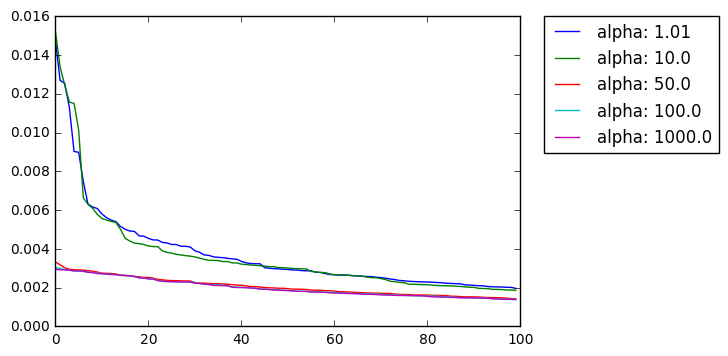

In [37]:
for topic in topics_distributions_with_alpha:
    plt.plot(topic[0][1][:100], label='alpha: ' + str(topic[1]))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We can see here that a high value for alpha will make the distribution of words closer to a uniform distribution

### Impact of beta on topics

In order to get an idea of the impact of the parameter beta on the topics, we generate some models using different values for beta.

Then, for each model we generated, we pick the first topic and look at how the words are distributed. We display the words and their corresponding weights for the highest values and we plot the weight distribution of the first 100 words.

In [22]:
betas = [1.01, 10.0, 100.0, 1000.0]

beta_topics_distributions = [model_fixed_alpha(beta).describeTopics()[0] for beta in betas]

In [23]:
pprint(topic_summary(beta_topics_distributions))

[[('control', 0.016812003164259754),
  ('linear', 0.015540914017209263),
  ('programming', 0.013552008492884305),
  ('algorithm', 0.013304791672732663),
  ('network', 0.011510864021104754),
  ('optimization', 0.010814887621346705),
  ('computer', 0.008087482643547736),
  ('machine', 0.0073948658838023035),
  ('algebra', 0.006975873434881134),
  ('technique', 0.006540908247401891)],
 [('oral', 0.0030450947806618415),
  ('control', 0.0030393365926704814),
  ('ass', 0.0030206295250353073),
  ('group', 0.0029985015653567655),
  ('study', 0.002981509603295665),
  ('hour', 0.002980743730020821),
  ('systems', 0.0029696430471978902),
  ('important', 0.0029384680259461533),
  ('field', 0.0029017393627759494),
  ('e', 0.002831318429609918)],
 [('oral', 0.002950108117495416),
  ('ass', 0.0029161001633799177),
  ('group', 0.002890874291573545),
  ('study', 0.002890539624638235),
  ('hour', 0.00288207334661578),
  ('systems', 0.0028730231063832977),
  ('control', 0.002857977330171751),
  ('importa

In [24]:
beta_topics_distributions_with_beta = zip(beta_topics_distributions, betas)

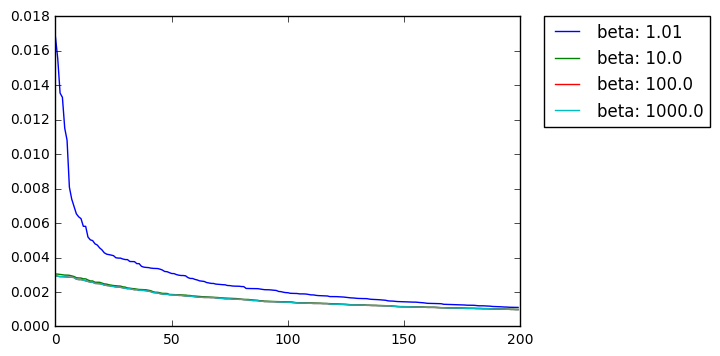

In [25]:
for topic in beta_topics_distributions_with_beta:
    plt.plot(topic[0][1][:200], label='beta: ' + str(topic[1]))   
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Here we can see that high value for beta will make the distribution closer to a uniform distribution. 

## Exercise 4.10: EPFL's taught subjects

<p>We know that there are roughly 24 sections at EPFL. Thus we made the assumption that there are 24 mains topics.</p> 
<p>Even if courses can be composed of different scientific fields, they usually are attached to one specific domain. Thus we had to set a low value for alpha. After a bit of tweaking we found the value of 1.3 which was the best we could achieve.</p>
<p>For the beta value, we set the value to 1.55 because we had to keep it quite low. Indeed, course descriptions can usually be summarized with a few keywords. </p>


k = 24

alpha = 1.3

beta = 1.55

In [76]:
EPFLmodel = LDA.train(rdd, k=24, docConcentration=1.3, topicConcentration=1.55, seed=1)

topics = list(zip(range(24), retrieve_best_words(EPFLmodel)))

In [77]:
pprint(topics)

[(0,
  ['e',
   'mass',
   'heat',
   'transfer',
   'equation',
   'flow',
   'conversion',
   'fluid',
   'chemical',
   'state',
   'thermodynamic',
   'phase',
   'property',
   'thermodynamics',
   'principle',
   'mechanic',
   'law',
   'pressure',
   'apply',
   'equilibrium']),
 (1,
  ['algorithm',
   'convex',
   'image',
   'programming',
   'negotiation',
   'object',
   'parallel',
   'graph',
   'algorithms',
   'construction',
   'visual',
   'optimization',
   'space',
   'complexity',
   'memory',
   'computer',
   'program',
   'machine',
   'role',
   'software']),
 (2,
  ['cell',
   'chemical',
   'biology',
   'chemistry',
   'protein',
   'molecular',
   'reaction',
   'note',
   'biological',
   'mechanism',
   'students',
   'development',
   'reactor',
   'drug',
   'cancer',
   'disease',
   'important',
   'cellular',
   'metal',
   'study']),
 (3,
  ['communication',
   'analog',
   'verification',
   'signal',
   'digital',
   'machine',
   'mixed',
   'cir

0: Physics - thermodynamics

1: Computer science

2: Life science - health

3: Communication systems

4: Management of technology

5: Not clear

6: Microengineering

7: Mathematics

8: Material science and engineering

9: Physics - waves

10: Not clear - Technology and Public Policy ?

11: Architecture

12: Data science

13: Environmental Engineering

14: Robotics - not clear

15: Quantum physics - not clear

16: Physics

17: Bioengineering

18: Physics - optics

19: Management of technology - finance

20: Electrical engineering

21: Communication systems

22: Physics - astronomy

23: Mechanical Engineering


## Exercise 4.11: Wikipedia structure

In [3]:
import json

data = sc.textFile("/ix/wikipedia-for-schools.txt").map(json.loads)
doc_count = data.count()
titles = dict(data.map(lambda o: (o['page_id'], o['title'])).collect())
terms = data.flatMap(lambda o: o['tokens']).distinct().collect()
terms_count = len(terms)
term_to_index = {w: i for i, w in enumerate(terms)}
local_data = data.map(lambda o: (o['page_id'], o['tokens'])).collect()

from collections import Counter
def create_vec(doc_tokens):
    indexes = []
    c = Counter()
    for w in doc_tokens:
        indexes.append([term_to_index[w]])
        c[term_to_index[w]] += 1
    data = [(i, c[i]) for i in c]
    return Vectors.sparse(len(terms), data)

wiki_rdd = sc.parallelize([[page_id, create_vec(tokens)] for page_id, tokens in local_data])

In [4]:
wikiModel = LDA.train(wiki_rdd, k=9, docConcentration=1.3, topicConcentration=2.11, seed=1)

In [ ]:
retrieve_best_words_wiki = lambda model: [[terms[i] for i in indices[:20]] for indices, weights in model.describeTopics(maxTermsPerTopic=15)]
wiki_topics = list(zip(range(9), retrieve_best_words_wiki(wikiModel)))

We set the number of topics to 9 because wikipedia says that they have 6 main categories but they seem to not span all general categories so we decided to add a few topics.

While executing the `describeTopics` function we encounter many java errors that we do not know how to solve.